In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
data = pd.read_pickle("C:/1. Power grid frequency data/df_South_Korea_cleansed_2024-08-15_2024-12-10.pkl")

data.index = pd.to_datetime(data.index)

# Step 1: Filter for rows where QI == 0 and no NaN in any relevant column
data_filtered = data[(data['QI'] == 0) & (data['freq'].notna())].dropna()

# Recheck for NaN
print("NaN Summary after filtering for QI and freq in data_filtered:")
print(data_filtered.isna().sum())

# Step 2: Group the data by the hour
hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))

# Step 3: Filter out incomplete hours 
valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)

# Step 4: Extract the 'freq' column and add a 'Time' column
valid_hours['Time'] = valid_hours.index  #
freq = valid_hours['freq']

# Validate that valid_hours is a multiple of 3600
print(f"Total rows in valid_hours: {len(valid_hours)}")
print(f"Is valid_hours a multiple of 3600? {len(valid_hours) % 3600 == 0}")


NaN Summary after filtering for QI and freq in data_filtered:
freq    0
QI      0
dtype: int64


C:\Users\wp7528\AppData\Local\Temp\ipykernel_22228\1879534582.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_groups = data_filtered.groupby(data_filtered.index.floor('H'))


Total rows in valid_hours: 8823600
Is valid_hours a multiple of 3600? True


In [3]:
# Look the first 10 rows of valid_hours
print(valid_hours.head(10))


                          freq QI                Time
2024-08-15 01:00:00  59.974473  0 2024-08-15 01:00:00
2024-08-15 01:00:01  59.975651  0 2024-08-15 01:00:01
2024-08-15 01:00:02  59.977579  0 2024-08-15 01:00:02
2024-08-15 01:00:03  59.976437  0 2024-08-15 01:00:03
2024-08-15 01:00:04  59.974978  0 2024-08-15 01:00:04
2024-08-15 01:00:05  59.973959  0 2024-08-15 01:00:05
2024-08-15 01:00:06  59.977355  0 2024-08-15 01:00:06
2024-08-15 01:00:07  59.976714  0 2024-08-15 01:00:07
2024-08-15 01:00:08  59.977276  0 2024-08-15 01:00:08
2024-08-15 01:00:09  59.978177  0 2024-08-15 01:00:09


In [4]:
# Delete QI column and convert frequency to omega and add 'omega' column
valid_hours.drop(columns=['QI'], inplace=True)
valid_hours['omega'] = 2 * np.pi * (valid_hours['freq'] - 60)

In [5]:
# Look the first 10 rows of valid_hours
print(valid_hours.head(10))
len(valid_hours)/3600

                          freq                Time     omega
2024-08-15 01:00:00  59.974473 2024-08-15 01:00:00 -0.160393
2024-08-15 01:00:01  59.975651 2024-08-15 01:00:01 -0.152990
2024-08-15 01:00:02  59.977579 2024-08-15 01:00:02 -0.140874
2024-08-15 01:00:03  59.976437 2024-08-15 01:00:03 -0.148052
2024-08-15 01:00:04  59.974978 2024-08-15 01:00:04 -0.157216
2024-08-15 01:00:05  59.973959 2024-08-15 01:00:05 -0.163623
2024-08-15 01:00:06  59.977355 2024-08-15 01:00:06 -0.142285
2024-08-15 01:00:07  59.976714 2024-08-15 01:00:07 -0.146311
2024-08-15 01:00:08  59.977276 2024-08-15 01:00:08 -0.142779
2024-08-15 01:00:09  59.978177 2024-08-15 01:00:09 -0.137119


2451.0

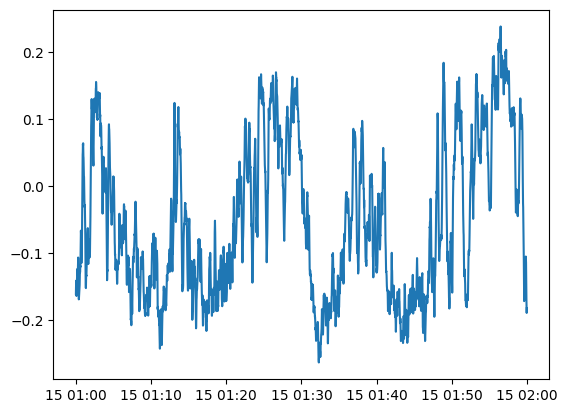

In [5]:
# Plot the omega data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA



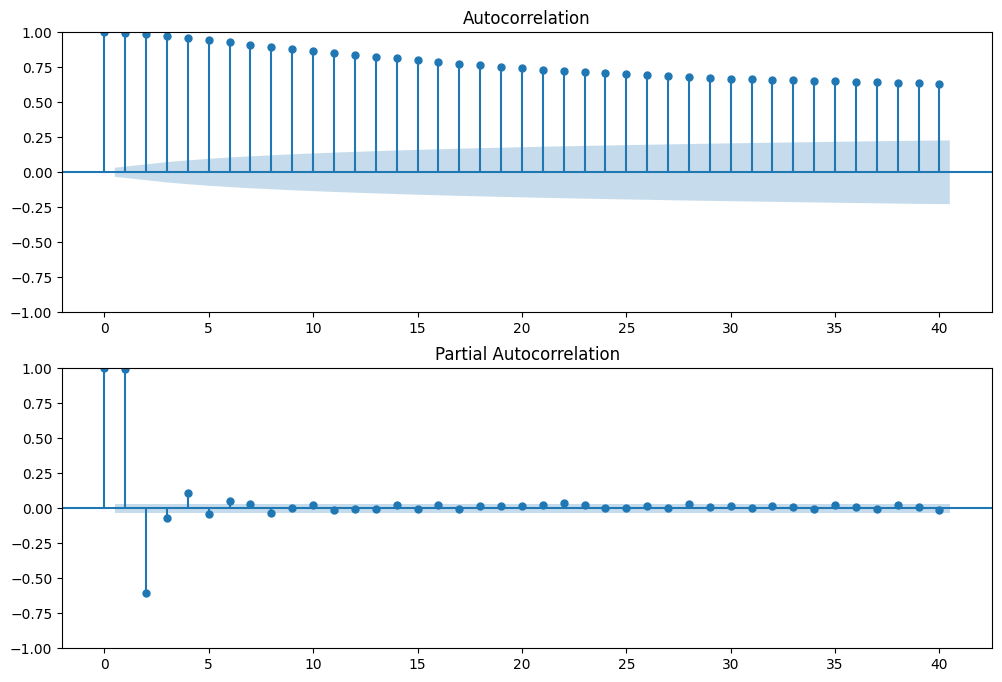

In [7]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(valid_hours['omega'][0:3600].values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(valid_hours['omega'][0:3600].values, lags=40, ax=ax2)


In [9]:
arma_mod20 = ARIMA(valid_hours['omega'][0:3600].values, order=(2, 0, 0)).fit()
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)


[-5.13718768e-02  1.64347543e+00 -6.50103745e-01  6.03396465e-05]
-24745.250658165998 -24720.495901668222 -24736.428627550085


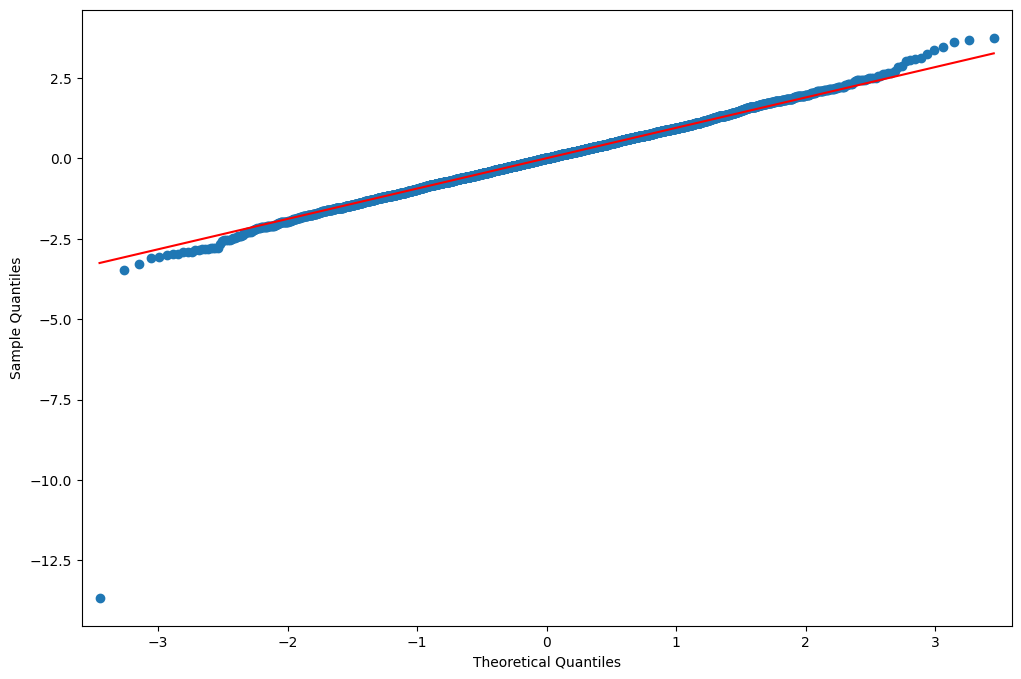

In [10]:
from statsmodels.graphics.api import qqplot

resid = arma_mod20.resid
stats.normaltest(resid)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)



In [5]:
valid_hours['omega'].values.squeeze()

array([-0.16039319, -0.15298993, -0.14087405, ...,  0.10080812,
        0.11339232,  0.13361377])

In [6]:
def integrate_data(data, dt=1):
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt 
    return integrated_data


In [7]:
from scipy.integrate import cumtrapz

def integrate_data(omega_data, dt=1, initial_theta=0):
    theta_data = cumtrapz(omega_data, dx=dt, initial=initial_theta)
    return theta_data

In [8]:
# Integrate the omega data and call it theta and add 'theta' column
valid_hours['theta'] = integrate_data(valid_hours['omega'],1)


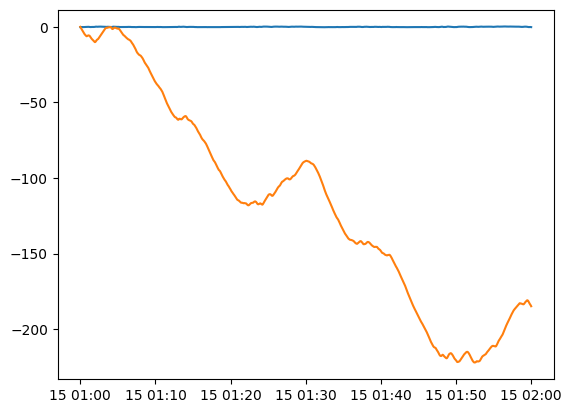

In [10]:
# Plot the omega and theta data (ONE DAY)
plt.plot(valid_hours['omega'][0:3600])
plt.plot(valid_hours['theta'][0:3600])



In [9]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, region_name, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with the specified region name
        chunk['Region'] = region_name
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with the specified region name
        remaining_chunk['Region'] = region_name
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [10]:
# Apply Gaussian filter to the omega data
filtered_data = apply_gaussian_filter(valid_hours['omega'], 'South Korea')


In [17]:
# Check the number of chunks created
print(f"Number of chunks created: {len(filtered_data)}")
filtered_data

Number of chunks created: 2451


[                        omega  omega_filtered       Region
 2024-08-15 01:00:00 -0.160393       -0.086092  South Korea
 2024-08-15 01:00:01 -0.152990       -0.086075  South Korea
 2024-08-15 01:00:02 -0.140874       -0.086040  South Korea
 2024-08-15 01:00:03 -0.148052       -0.085989  South Korea
 2024-08-15 01:00:04 -0.157216       -0.085920  South Korea
 ...                       ...             ...          ...
 2024-08-15 01:59:55 -0.153148       -0.015374  South Korea
 2024-08-15 01:59:56 -0.168694       -0.015464  South Korea
 2024-08-15 01:59:57 -0.177234       -0.015531  South Korea
 2024-08-15 01:59:58 -0.188864       -0.015576  South Korea
 2024-08-15 01:59:59 -0.181731       -0.015599  South Korea
 
 [3600 rows x 3 columns],
                         omega  omega_filtered       Region
 2024-08-15 02:00:00 -0.170663       -0.021602  South Korea
 2024-08-15 02:00:01 -0.162034       -0.021608  South Korea
 2024-08-15 02:00:02 -0.148849       -0.021621  South Korea
 2024-08-15 

In [15]:
def calculate_sindy_models(region_data, region_name, n=2):
    sindy_models = []
    #scores = []  # List to store model scores
    
    for chunk in region_data:
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        
        feature_names_chunk = ["theta", "omega", "time"]
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
        
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)
        
        model_chunk.fit(x_train_augmented_chunk, t=1)
        sindy_models.append(model_chunk)
        
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", score)
        #print()
        print("t_train_chunk:", t_train_chunk)

    
    return sindy_models

In [16]:
# Fit SINDy models to the filtered data
sindy_models = calculate_sindy_models(filtered_data, 'South Korea')


t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 ... 3597 3598 3599]
t_train_chunk: [   0    1    2 

In [22]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [17]:
def calculate_sindy_models_abs(region_data, region_name, n=2):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        #print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []
    
    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return mean_coefficients, std_coefficients

In [23]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = []
    scores = []

    for chunk in region_data:
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        
        feature_names_chunk = ["theta", "omega", "time"]
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
        
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)
        
        model_chunk.fit(x_train_augmented_chunk, t=1)
        sindy_models.append(model_chunk)
        
        score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
        scores.append(score)
        
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", score)
        #print()
    
    mean_score = np.mean(scores)
    print(f"Mean Model Score for {region_name}: {mean_score}")
    
    return sindy_models

In [19]:
skmean, skstd = calculate_sindy_models_abs(filtered_data, 'South Korea', n=2)

Mean Coefficients for South Korea:
[[ 3.64005132e-07  2.42289279e-08  9.99967995e-01  5.68995852e-09
  -1.22959748e-10 -1.81791968e-08  1.40818121e-10  1.47875320e-05
   1.84688961e-08  5.97247697e-12]
 [ 9.58567342e-05 -3.71098491e-05 -1.94934691e-03  3.05144387e-06
  -1.91347462e-08  3.51334102e-05  4.40280939e-08  1.54448570e-03
   5.57656993e-06  1.95773059e-09]
 [ 1.00000000e+00 -3.52939511e-19 -3.81994861e-16  1.93226685e-17
  -4.98844568e-18 -1.14679314e-16  1.56238593e-18 -2.55734739e-14
   9.29850197e-17  7.83144906e-20]]
Standard Deviation of Coefficients for South Korea:
[[4.77219032e-06 1.19957349e-07 3.09810803e-05 7.38766917e-09
  2.53722310e-09 5.11326878e-07 3.16150356e-10 1.16096514e-04
  2.77024799e-08 1.82912696e-11]
 [1.21851184e-03 4.51482044e-05 7.20931349e-03 3.39896294e-06
  7.15589293e-07 1.35868371e-04 7.65896551e-08 2.50084523e-02
  9.49748044e-06 4.94629612e-09]
 [1.71232832e-14 5.13953121e-16 4.75591741e-14 3.72390812e-17
  4.82867290e-17 1.87217878e-15 7.3

In [20]:
sk_score=calculate_model_scores(filtered_data, 'South Korea', n=2)

Mean Model Score for South Korea: 0.48315214251885213


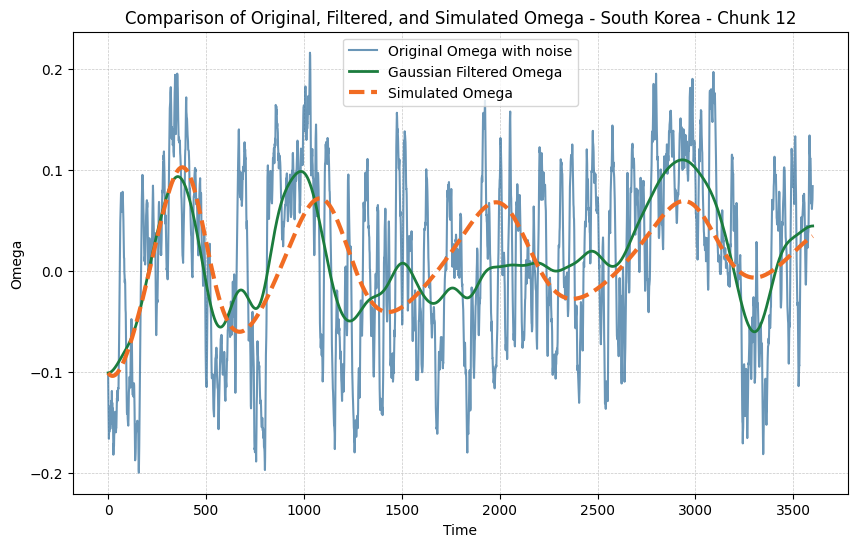

In [21]:
n = 11
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 17)
simulate_sindy_model(sindy_models[n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [24]:
def plot_coefficients_for_regions(region_data, feature_names):
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    
    markers = ['o', 's', '^']
    region_names = list(region_data.keys())
    n_regions = len(region_names)
    bar_width = 0.2  # Width of space to allocate to each region's marker

    # Calculate the total width occupied by all the regions' markers
    total_width = bar_width * n_regions

    # Calculate the offset to center the feature names
    center_offset = total_width / 2 - bar_width / 2

    region_colors = {'South Korea': '#1b9e77'}

    for region_name, data in region_data.items():
        means, stds = data['means'], data['stds']
        n_features = means.shape[1]
        
        # Select the marker for the region
        marker = markers[region_names.index(region_name) % len(markers)]
        region_offset = bar_width * region_names.index(region_name)

        for i in range(n_features):
            # Apply offset for each region to center the markers
            ax.errorbar(i + region_offset, np.abs(means[1, i]), yerr=stds[1, i], fmt=marker, label=region_name if i == 0 else "", color=region_colors[region_name])

    ax.legend(fontsize=16, title_fontsize=16, frameon=False)
    ax.set_xticks(np.arange(n_features) + center_offset)
    ax.set_xticklabels(feature_names, fontsize=16)
    ax.set_ylabel("Coefficient Value", fontsize=16)
    ax.set_xlabel("Feature Candidates", fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title("Coefficients with Error Bars for South Korea", fontsize=20)
    
    ax.set_yscale('log')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    
    return ax  # Return the ax object

<Axes: title={'center': 'Coefficients with Error Bars for South Korea'}, xlabel='Feature Candidates', ylabel='Coefficient Value'>

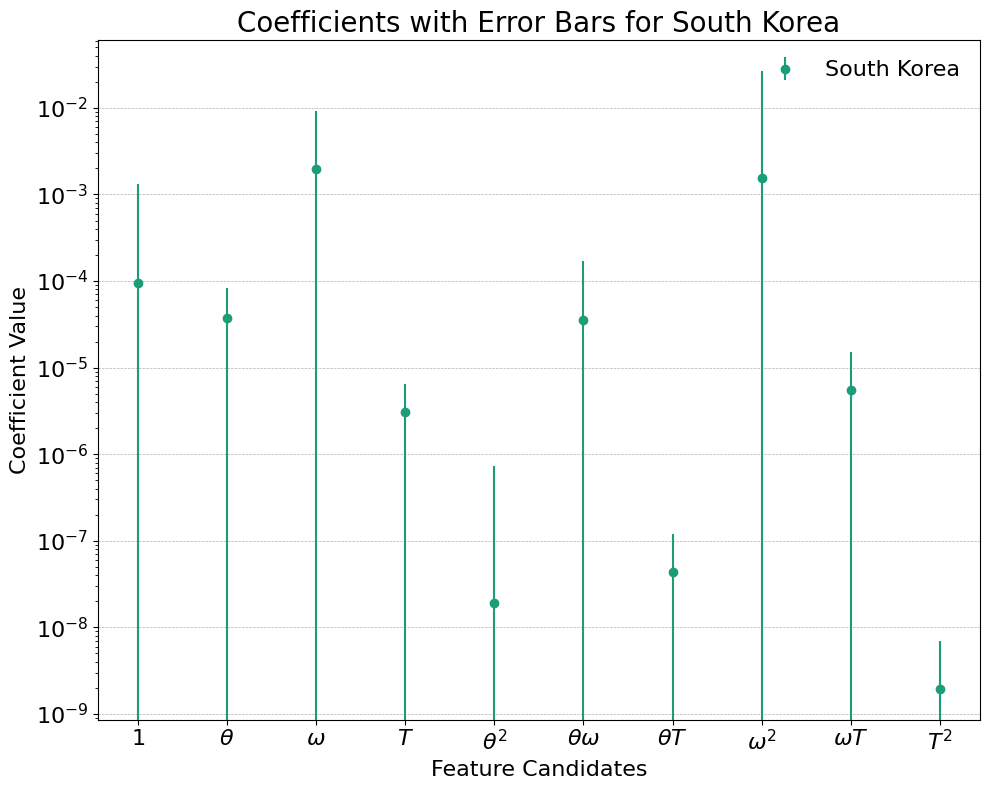

In [26]:
feature_names = ['$1$', r'$\theta$', r'$\omega$', r'$T$', 
                r'$\theta^2$', r'$\theta\omega$', r'$\theta T$', r'$\omega^2$', 
                r'$\omega T$',r'$T^2$']
#apply plot_coefficients_for_regions function for South Korea
plot_coefficients_for_regions({'South Korea': {'means': skmean, 'stds': skstd}}, feature_names)

In [61]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = []
    scores = []

    for chunk in region_data:
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # 计算非线性时间
        #t_train_chunk = (chunk.index - chunk.index[0]).total_seconds().to_numpy().reshape(-1, 1)

        # 时间随角速度变化
        t_train_chunk = np.cumsum(np.abs(chunk['omega_filtered'].values)).reshape(-1, 1)
        # 时间随角度变化
        #t_train_chunk = np.cumsum(np.abs(theta_chunk)).reshape(-1, 1)


        # 对数时间
        #t_train_chunk = np.log1p((chunk.index - chunk.index[0]).total_seconds().to_numpy()).reshape(-1, 1)

        # 平方时间
        #t_train_chunk = ((chunk.index - chunk.index[0]).total_seconds().to_numpy() ** 2).reshape(-1, 1)
        # 指数时间
        #t_train_chunk = (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1)

        # 线性时间
        #t_train_chunk = np.arange(0, len(stacked_data_chunk), 1).reshape(-1, 1)

        x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
        
        feature_names_chunk = ["theta", "omega", "time"]
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
        
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)
        
        model_chunk.fit(x_train_augmented_chunk, t=1)
        sindy_models.append(model_chunk)
        
        score = model_chunk.score(x_train_augmented_chunk, t=1, metric=explained_variance_score)
        scores.append(score)
        
        #print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        #model_chunk.print(precision=7)
        #print("Model Score:", score)
        #print()
    
    mean_score = np.mean(scores)
    print(f"Mean Model Score for {region_name}: {mean_score}")
    
    return sindy_models

In [62]:
sindykorea = calculate_model_scores(filtered_data, 'South Korea', n=2)


Mean Model Score for South Korea: 0.7824742020971565


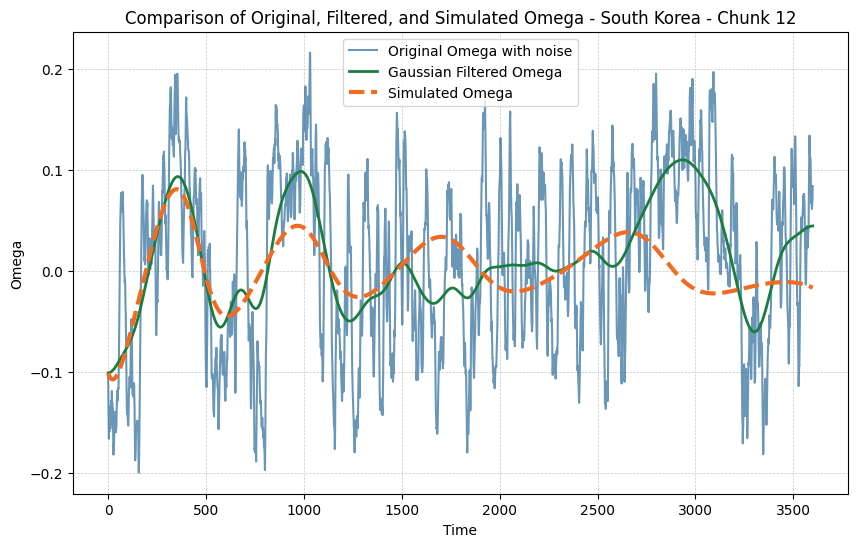

In [64]:
n = 11
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]  # Adding initial time condition

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 12)
#simulate_sindy_model(sindykorea[n], initial_conditions, time_points[0:3000], f'South Korea - Chunk {n+1}', omega_original[0:3000], omega_filtered[0:3000])
simulate_sindy_model(sindykorea[n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [54]:
from sklearn.metrics import explained_variance_score
import numpy as np
import pysindy as ps

def calculate_model_scores(region_data, region_name, n=2):
    sindy_models = []
    scores_var = []  # 存储 explained_variance_score
    scores_max_err = []  # 存储 max_error

    for chunk in region_data:
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # 指数时间变换
        t_train_chunk = (np.exp((chunk.index - chunk.index[0]).total_seconds().to_numpy() / 1000) - 1).reshape(-1, 1)

        x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
        
        feature_names_chunk = ["theta", "omega", "time"]
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
        
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)
        
        model_chunk.fit(x_train_augmented_chunk, t=1)
        sindy_models.append(model_chunk)

        # 预测数据
        x_pred = model_chunk.predict(x_train_augmented_chunk)

        # 计算解释方差分数
        score_var = explained_variance_score(x_train_augmented_chunk, x_pred)
        scores_var.append(score_var)

        # 计算最大误差
        max_errors = np.max(np.abs(x_train_augmented_chunk - x_pred), axis=0)
        score_max_err = np.max(max_errors)
        scores_max_err.append(score_max_err)
    
    # 计算平均评分
    mean_var_score = np.mean(scores_var)
    mean_max_error = np.mean(scores_max_err)

    print(f"Mean Explained Variance Score for {region_name}: {mean_var_score:.4f}")
    print(f"Mean Max Error for {region_name}: {mean_max_error:.4f}")
    
    return sindy_models
sindykorea = calculate_model_scores(filtered_data, 'South Korea', n=2)

Mean Explained Variance Score for South Korea: 0.0006
Mean Max Error for South Korea: 187.2547


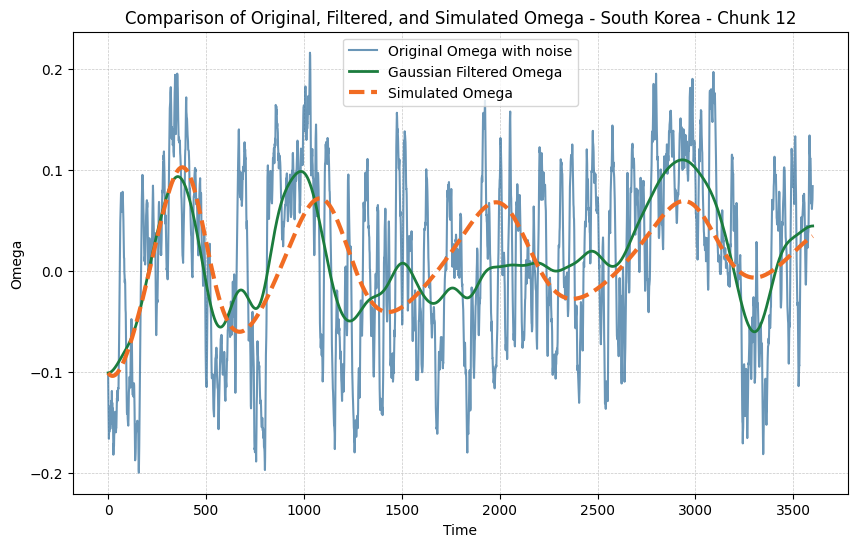

In [25]:
n = 11
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]  # Adding initial time condition

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 12)
simulate_sindy_model(sindy_nl_time[n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

In [35]:
def sindy_nl_time_models(region_data, region_name, n=2):
    sindy_models = []
    #scores = []  # List to store model scores
    
    for chunk in region_data:
        theta_chunk = integrate_data(chunk['omega_filtered'].values)
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))
        # 时间随角速度变化
        #t_train_chunk = np.cumsum(np.abs(chunk['omega_filtered'].values)).reshape(-1, 1)
        # 时间随角度变化
        t_train_chunk = np.cumsum(np.abs(theta_chunk)).reshape(-1, 1)


        # 对数时间
        #t_train_chunk = np.log1p((chunk.index - chunk.index[0]).total_seconds()).reshape(-1, 1)
        # 平方时间
        #t_train_chunk = ((chunk.index - chunk.index[0]).total_seconds() ** 2).reshape(-1, 1)
        # 指数时间
        #t_train_chunk = (np.exp((chunk.index - chunk.index[0]).total_seconds() / 1000) - 1).reshape(-1, 1)




        x_train_augmented_chunk = np.hstack([stacked_data_chunk, t_train_chunk])
        
        feature_names_chunk = ["theta", "omega", "time"]
        polynomial_library_chunk = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)
        
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)
        
        model_chunk.fit(x_train_augmented_chunk, t=1)
        sindy_models.append(model_chunk)
    
    return sindy_models

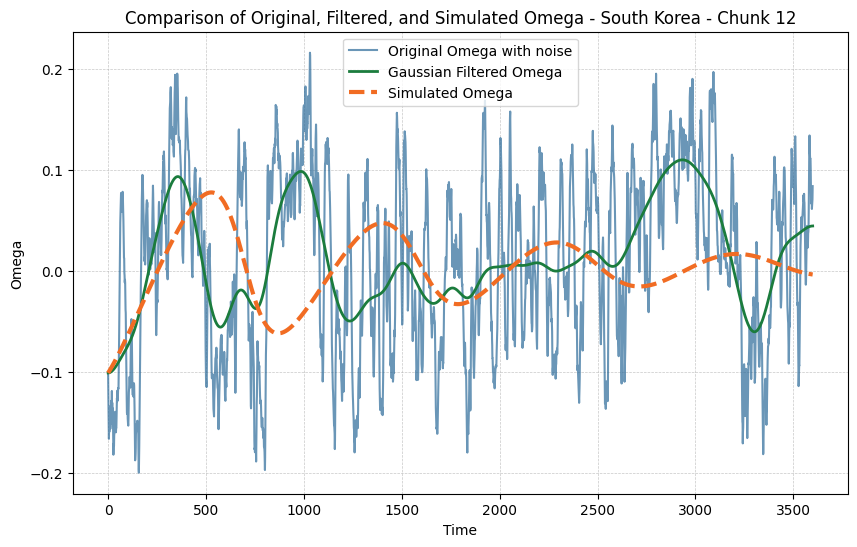

In [36]:
sindy_nl_time=sindy_nl_time_models(filtered_data, 'South Korea', n=2)

n = 11
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]  # Adding initial time condition

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 12)
simulate_sindy_model(sindy_nl_time[n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)

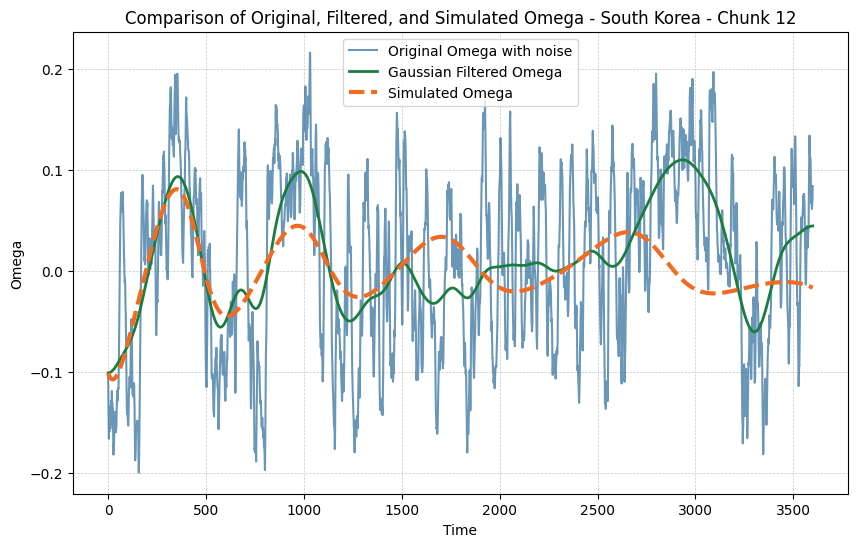

In [34]:

n = 11
initial_conditions = [integrate_data(filtered_data[n]['omega_filtered'].values)[0], 
                      filtered_data[n]['omega_filtered'].iloc[0], 0]  # Adding initial time condition

# Define time points for simulation
total_time = len(filtered_data[n]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = filtered_data[n]['omega'].values  
omega_filtered = filtered_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 12)
simulate_sindy_model(sindy_nl_time[n], initial_conditions, time_points, f'South Korea - Chunk {n+1}', omega_original, omega_filtered)